# Handwritten Digits Generation

In this notebook, we'll be building handwritten digits generation models. Two methods are used:
1. Generative Adversarial Network (GAN)
2. Deep Convolutional GAN (DCGAN)

MNIST dataset will be used to train the models.

### Table of Content
- [0.0. Preparation](#0.0.)
  - [0.1. Import the data](#0.1.)
  - [0.2. Visualize the data](#0.2.)
  - [0.2. Pre-processing: scaling from -1 to 1 ](#0.3.)<br>
  <br>
- [1.0. Generative Adversarial Network](#1.0.)
  - [1.1. Define the model](#1.1.)
    - [1.1.1. Discriminator](#1.1.1.)
    - [1.1.2. Generator](#1.1.2.)
    - [1.1.3. Model hyperparameters](#1.1.3.)
    - [1.1.4. Build complete network](#1.1.4.)<br>
    <br>
  - [1.2. Discriminator and generator loss](#1.2.)
    - [1.2.1. Discriminator loss](#1.2.1.)
    - [1.2.2. Generator loss](#1.2.2.)
    - [1.2.3. Optimizers](#1.2.3.)<br>
    <br>
  - [1.3. Training](#1.3.)
  - [1.4. Training loss](#1.4.)
  - [1.5. Generator samples from training](#1.5.)
  - [1.6. Sampling from the generator](#1.6.)<br>
  <br>  
- [2.0. Deep Convolutional Generative Adversarial Network](#2.0.)
  - [2.1. Define the model](#2.1.)
    - [2.1.1. Discriminator](#2.1.1.)
    - [2.1.2. Generator](#2.1.2.)
    - [2.1.3. Build complete network](#2.1.3.)
    - [2.1.4. Training on GPU](#2.1.4.)<br>
    <br>
  - [2.2. Discriminator and generator loss](#2.2.)
    - [2.2.1. Discriminator loss](#2.2.1.)
    - [2.2.2. Generator loss](#2.2.2.)
    - [2.2.3. Optimizers](#2.2.3.)<br>
    <br>
  - [2.3. Training](#2.3.)
  - [2.4. Training loss](#2.4.)
  - [2.5. Generator samples from training](#2.5.)

---
## 0.0. Preparation <a id="0.0."></a>

In [198]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

### 0.1. Import the data <a id="0.1."></a>

In [199]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### 0.2. Visualize the data <a id="0.2."></a>

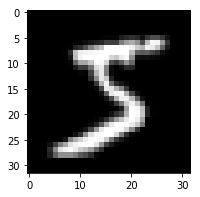

In [200]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### 0.3. Pre-processing: scaling from -1 to 1 <a id="0.3."></a>
We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [201]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  0.0
Max:  0.99215686


In [202]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x

In [203]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  -1.0
Scaled max:  0.9843137


---
## 1.0. Generative Adversarial Network <a id="1.0."></a>

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

---
### 1.1. Define the model <a id="1.1."></a>

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### 1.1.1. Discriminator <a id="1.1.1."></a>

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [211]:
## import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(input_size, 4*hidden_dim)
        self.fc2 = nn.Linear(4*hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        # final layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 32 * 32)
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)

        return x


### 1.1.2. Generator <a id="1.1.2."></a>

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

We'll do this in the training loop, later on.

In [212]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, 4*hidden_dim)
        # final layer
        self.fc4 = nn.Linear(4*hidden_dim, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer 
        x = F.tanh(self.fc4(x))
        
        return x

### 1.1.3. Model hyperparameters <a id="1.1.3."></a>

In [213]:
# Discriminator hyperparams

# Size of input image to discriminator
input_size = 32 * 32
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 32 * 32
# Size of *first* hidden layer in the generator
g_hidden_size = 32

### 1.1.4. Build complete network <a id="1.1.4."></a>

Now we're instantiating the discriminator and generator from the classes defined above. 

In [214]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as we expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1024, bias=True)
  (dropout): Dropout(p=0.3)
)


---
### 1.2. Discriminator and generator loss <a id="1.2."></a>

Now we need to calculate the losses. 

### 1.2.1 Discriminator loss <a id="1.2.1."></a>

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### 1.2.2. Generator loss <a id="1.2.2."></a>

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [215]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # smooth labels if smooth=True
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    # compare logits to real labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    # compare logits to fake labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

### 1.2.3. Optimizers <a id="1.2.3."></a>

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [216]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
### 1.3. Training <a id="1.3."></a>

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

#### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

#### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [218]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = scale(real_images) # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
                
        # 1. Train with real images

        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('GAN_model.pkl', 'wb') as f:
    pkl.dump(samples, f)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 0.8495 | g_loss: 2.7906
Epoch [    1/   50] | d_loss: 0.8768 | g_loss: 1.7570
Epoch [    1/   50] | d_loss: 1.0222 | g_loss: 1.0744
Epoch [    2/   50] | d_loss: 0.9598 | g_loss: 1.1178
Epoch [    2/   50] | d_loss: 0.9935 | g_loss: 1.1254
Epoch [    2/   50] | d_loss: 1.1981 | g_loss: 1.3074
Epoch [    3/   50] | d_loss: 1.0183 | g_loss: 0.9736
Epoch [    3/   50] | d_loss: 0.8513 | g_loss: 2.6805
Epoch [    3/   50] | d_loss: 1.2598 | g_loss: 1.4123
Epoch [    4/   50] | d_loss: 1.3903 | g_loss: 1.1376
Epoch [    4/   50] | d_loss: 1.2641 | g_loss: 0.8290
Epoch [    4/   50] | d_loss: 1.2853 | g_loss: 1.2991
Epoch [    5/   50] | d_loss: 1.1544 | g_loss: 2.1589
Epoch [    5/   50] | d_loss: 1.2642 | g_loss: 0.8460
Epoch [    5/   50] | d_loss: 1.2973 | g_loss: 1.5470
Epoch [    6/   50] | d_loss: 1.1789 | g_loss: 1.1485
Epoch [    6/   50] | d_loss: 1.0069 | g_loss: 1.3597
Epoch [    6/   50] | d_loss: 1.1324 | g_loss: 1.2024
Epoch [    7/   50] | d_loss

---
### 1.4. Training loss <a id="1.4."></a>

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

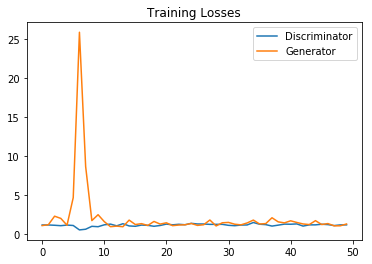

In [219]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

---
### 1.5. Generator samples from training <a id="1.5."></a>

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [223]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32)), cmap='Greys_r')

In [224]:
# Load samples from generator, taken while training
with open('GAN_model.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. We can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

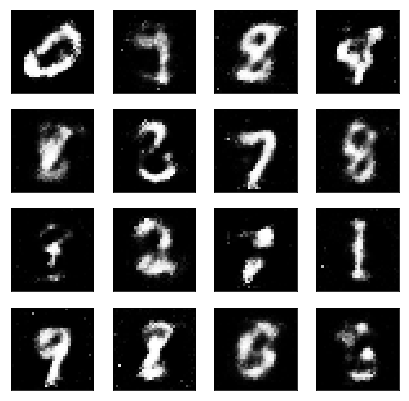

In [225]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

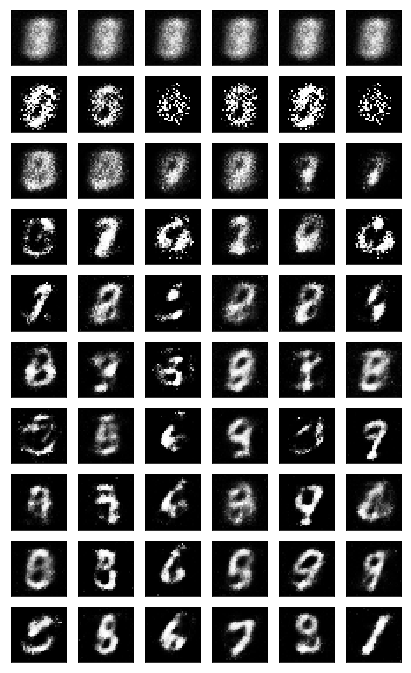

In [227]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((32,32)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. We can start to see some number like structures appear out of the noise like 1s and 9s.

---
### 1.6. Sampling from the generator <a id="1.6."></a>

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


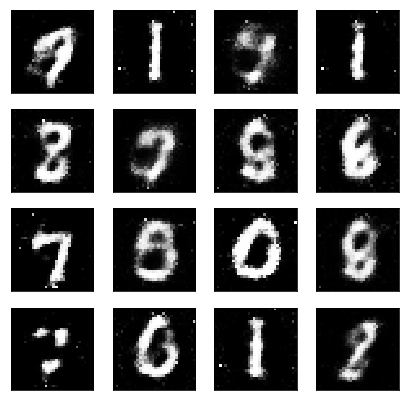

In [228]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

---
## 2.0. Deep Convolutional Generative Adversarial Network <a id="2.0."></a>
### 2.1. Define the model <a id="2.1."></a>
Similar with GAN, DCGAN is comprised of two adversarial networks, a discriminator and a generator.

### 2.1.1. Discriminator <a id="2.1.1."></a>

This is similar with a regular convolutional classifier, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x1 tensor images
* We need a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later

<img src='assets/conv_discriminator.png' width=80%/>

For the depths of the convolutional layers, we start with 128 filters in the first layer, then double that depth as we add layers (to 256, 512, etc.). Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpooling layers.

We'll also want to use batch normalization with [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) on each layer **except** the first convolutional layer and final, linear output layer. 

#### Helper `conv` function 

In general, each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a convolutional + an optional batch norm layer. We'll create these using PyTorch's [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential), which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: We use a **kernel_size of 4** and a **stride of 2** for strided convolutions.

In [229]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [230]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # convolutional layers
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # fully connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # convolutional layers
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)
        
        return x
    

### 2.1.2. Generator <a id="2.1.2."></a>

Next, we'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output with size 32x32, which is the size of our MNIST images.

<img src='assets/conv_generator.png' width=80% />

What's new here is we'll use transpose convolutional layers to create our new images. 
* The first layer is a fully connected layer which is reshaped into a deep and narrow layer.
* Then, we use batch normalization and a leaky ReLU activation. 
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where we typically halve the depth and double the width and height of the previous layer. 
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a `tanh` activation.

#### Helper `deconv` function

For each of these layers, the general scheme is transpose convolution > batch norm > ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a transpose convolutional + an optional batch norm layer. We'll create these using PyTorch's Sequential container, which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that we use a **kernel_size of 4** and a **stride of 2** for transpose convolutions.

In [231]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """

    ## create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                              stride, padding, bias=False)
    
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [232]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        # transpose convolutional layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 1, 4, batch_norm=False)
        
    def forward(self, x):
        # fully connected + reshape
        x = self.fc(x)
        x = x.view(-1, conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x

### 2.1.3. Build complete network <a id="2.1.3."></a>

We define our models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [245]:
# define hyperparams
conv_dim = 128
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### 2.1.4. Training on GPU <a id="2.1.4."></a>

Check if we can train on GPU. If we can, we set this as a variable and move our models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [246]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

Training on CPU.


---
### 2.2. Discriminator and generator loss <a id="2.2."></a>

Now we need to calculate the losses. And this will be exactly the same as before.

### 2.2.1. Discriminator loss <a id="2.2.1."></a>

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### 2.2.2. Generator loss <a id="2.2.2."></a>

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [247]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### 2.2.3. Optimizers <a id="2.2.3."></a>

Not much new here, but notice how we are using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

#### Hyperparameters

DCGANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. 

In [248]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
### 2.3. Training <a id="2.3."></a>

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

#### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

#### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [249]:
import pickle as pkl

# training hyperparams
num_epochs = 5

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('DCGAN_model.pkl', 'wb') as f:
    pkl.dump(samples, f)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/    5] | d_loss: 1.4258 | g_loss: 1.0930
Epoch [    1/    5] | d_loss: 0.8147 | g_loss: 0.7944
Epoch [    1/    5] | d_loss: 1.1354 | g_loss: 4.1101
Epoch [    1/    5] | d_loss: 0.1921 | g_loss: 2.6343
Epoch [    2/    5] | d_loss: 1.2205 | g_loss: 0.5475
Epoch [    2/    5] | d_loss: 0.4390 | g_loss: 2.5513
Epoch [    2/    5] | d_loss: 0.6620 | g_loss: 1.6995
Epoch [    2/    5] | d_loss: 0.2513 | g_loss: 2.0495
Epoch [    3/    5] | d_loss: 0.3748 | g_loss: 1.3295
Epoch [    3/    5] | d_loss: 0.1759 | g_loss: 1.6763
Epoch [    3/    5] | d_loss: 0.5748 | g_loss: 2.5213
Epoch [    3/    5] | d_loss: 0.0332 | g_loss: 5.0944
Epoch [    4/    5] | d_loss: 0.4026 | g_loss: 6.6565
Epoch [    4/    5] | d_loss: 0.0999 | g_loss: 2.9449
Epoch [    4/    5] | d_loss: 0.0738 | g_loss: 4.2112
Epoch [    4/    5] | d_loss: 0.0964 | g_loss: 3.3404
Epoch [    5/    5] | d_loss: 0.0948 | g_loss: 3.6053
Epoch [    5/    5] | d_loss: 0.0825 | g_loss: 5.9882
Epoch [    5/    5] | d_loss

---
### 2.4. Training loss <a id="2.4."></a>

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

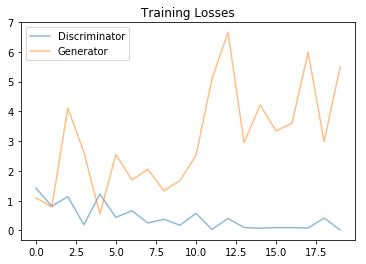

In [250]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
### 2.5. Generator samples from training <a id="2.5."></a>

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [251]:
# Load samples from generator, taken while training
with open('DCGAN_model.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. We can see the generator is able to reproduce numbers like 1, 7, 3, 6, 8. Since this is just a sample, it isn't representative of the full range of images this generator can make. The images generated from DCGAN model generally have better quality than the images generated than GAN model.

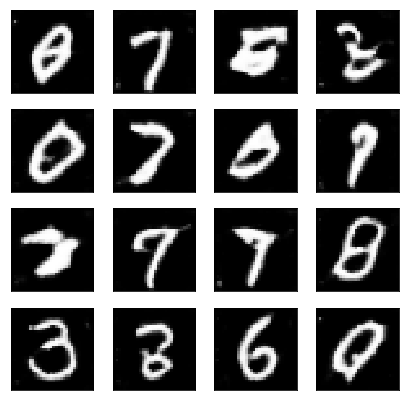

In [252]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)